# Описание ДЗ-2.

В второй домашке необходимо реализовать различные модификации градинетного спуска.

За дз можно получить максимум 10 баллов. **Домашки довольно творческие, если замечу копию нотбука у другого студента то максимальный балл сниижается до 3 )**

Разбалловка:
*   **Воспроизводимость и читабельность кода -  6 баллов** (все воспроизвелось и все понятно для проверяющего - 6 баллов; есть непонятные моменты, но все воспроизвелось - 4 балла; непонятный код и/или воспроизводится с небольшой правкой - 2 балл; непонятный код и/или ничего не воспроизвелось - 0 баллов).
*   **Технический отчет - 4 балла** (приведены результаты сравнения и выводы что сделали чтоб перебить baseline\другую модель, к примеру одна модель лучше/хуже нейронки и тд - 4 балла, только результаты - 2 балл, ничего нет - 0 баллов).


Присылать домашки по ссылке https://forms.gle/W8jwbwA4EWagEbX66

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Генерация выборки

Для наших целей будем использовать искуственно сгенерированные данные.

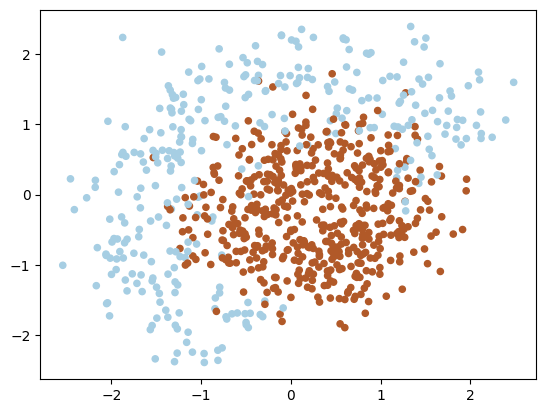

In [14]:
from sklearn import datasets, preprocessing

# keep random_state=42 for deterministic results
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4, random_state=42)
ind = np.logical_or(y == 1, X[:, 1] > X[:, 0] - 0.5)
X = X[ind, :]
m = np.array([[1, 1], [-2, 1]])
X = preprocessing.scale(X)
y = y[ind]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()

### [1] Варка фичей

Как вы можете заметить, данные не являются линейно разделимыми. Нам придётся добавить в обучающую выборку новые фичи либо использовать нелинейные модели. Предположим, что разделяющая поверхность имеет вид окружности. Добавьте в матрицу признаков дополнительные колонки $x_1^2$, $x_2^2$ и $x_1 \cdot x_2$.

In [15]:
def expand(X):
    """
    Добавляет квадратичные фичи.
    Для каждой строки матрицы находит строку
    [feature0, feature1, feature0^2, feature1^2, feature0*feature1, 1]

    :param X: матрица фичей, shape [n_samples,2]
    :returns: расширенная матрица фичей, shape [n_samples,6]
    """
    return np.column_stack([X, X[:, 0] ** 2, X[:, 1] ** 2, X[:, 0] * X[:, 1], np.ones(X.shape[0])])



### [3] Логистическая регрессия

Для классификации будем использовать логистическую регрессию.

$$ a(x; w) = \langle w, x \rangle $$
$$ P( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$


In [16]:
def probability(X, w):
    """
    Принимает на вход матрицу фичей и вектор весов
    Возвращает предсказание вероятность того, что y = 1 при фиксированных x, P(y=1|x)

    :param X: расширенная матрица фичей [n_samples,6] (expanded)
    :param w: вектор весов [6]
    :returns: вектор вероятностей
    """
    return 1 / (1 + np.exp(-np.dot(X, w)))

Для логистической регрессии оптимальный параметр находится минимизацией кросс-энтропии:

$$ L(w) =  - {1 \over \ell} \sum_{i=1}^\ell \left[ {y_i \cdot log P(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i = 1 \, | \, x_i,w))}\right] $$



In [17]:
def compute_loss(X, y, w):
    """
    Принимает на вход матрицу весов, вектор ответов и вектор весов.
    Выдаёт на выход значение функции потерь, расчитанное по формуле выше.
    """

    return -np.mean(y * np.log(probability(X, w)) + (1 - y) * np.log(1 - probability(X, w)))

Мы будем обучать модель методом градиентного спуска. Для этого нам придётся вычислить градиент функции потерь, представленной выше. Возьмите листочек, ручку и в бой!

$$ \nabla_w L = ...$$

Тут обойдёмся даже без матричного дифириенцирования. А вот в следущий раз его не миновать...

In [18]:
def compute_grad(X, y, w):
    """
    Нахоит значение градиента.
    """
    return np.dot(X.T, (probability(X, w) - y)) / X.shape[0]

Функция ниже предназначена для визуализации процесса обучения.

In [19]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

def visualize(X, y, w, history):
    """С помощью магии matplolib выдаёт красоты результатов классификации"""
    Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

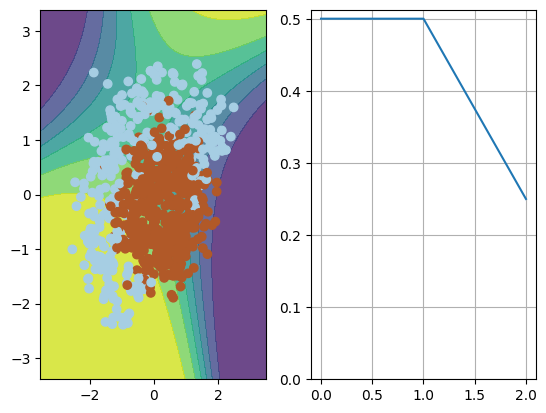

In [20]:
# убедитесь, что у вас она работает, запустив код ниже
# (он отработает если вы верно реализовали expend и probability)
dummy_weights = np.linspace(-1, 1, 6)
visualize(X, y, dummy_weights, [0.5, 0.5, 0.25])

## Обучение

Пришло время обучить нашу модель. Для этого вам придётся дописать кусочки функций ниже. Обязательно попробуйте поменять гиперпараметры (размер батча и скорость обучения) и посмотреть как будет изменяться анимация.

### [2] Mini-batch SGD

Берём несколько рандомных наблюдений и ищем градиент по ним!

$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$



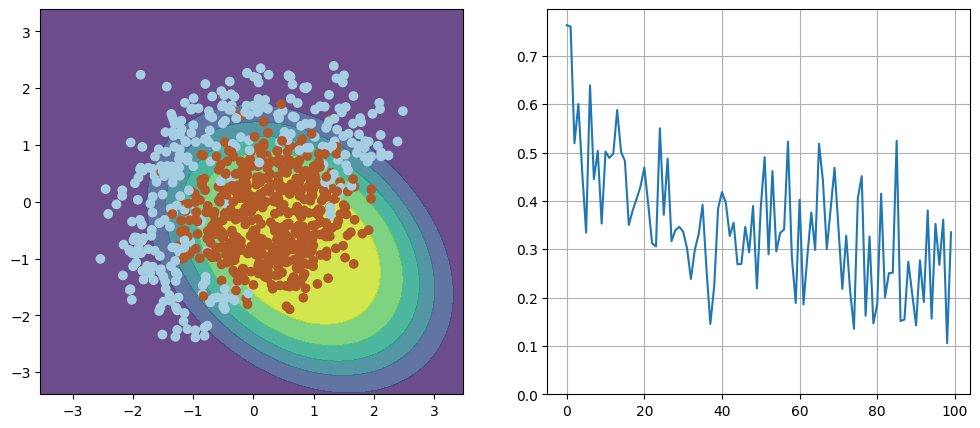

CPU times: user 622 ms, sys: 5.91 ms, total: 628 ms
Wall time: 597 ms


<Figure size 640x480 with 0 Axes>

In [33]:
%%time
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta= 0.1

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
  idx = np.random.choice(X.shape[0], size=batch_size)
  X_batch = expand(X[idx])
  y_batch = y[idx]

  grad = compute_grad(X_batch, y_batch, w)
  w = w - eta * grad

  loss[i] = compute_loss(X_batch, y_batch, w)


visualize(X, y, w, loss)
plt.clf()

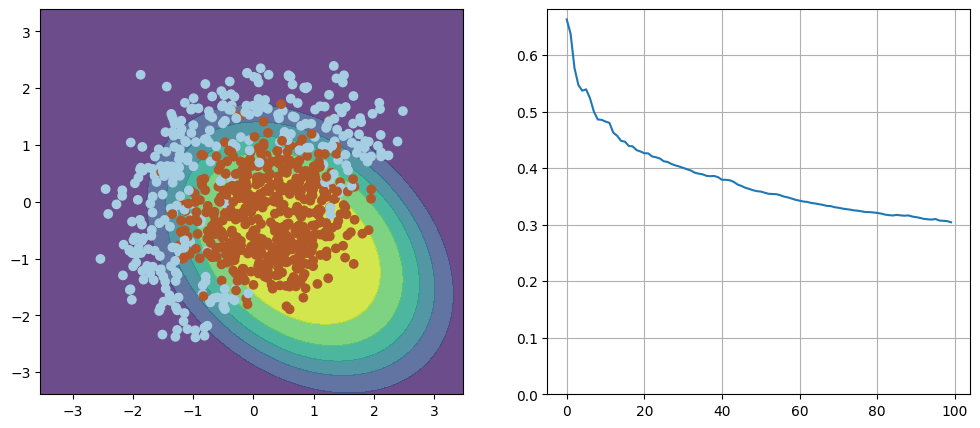

CPU times: user 531 ms, sys: 3.95 ms, total: 534 ms
Wall time: 414 ms


<Figure size 640x480 with 0 Axes>

In [32]:
%%time
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta= 0.1

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))


for i in range(n_iter):
  idx = np.random.choice(X.shape[0], size=batch_size)
  X_batch = expand(X[idx])
  y_batch = y[idx]

  grad = compute_grad(X_batch, y_batch, w)
  w = w - eta * grad

  loss[i] = compute_loss(expand(X), y, w)


visualize(X, y, w, loss)
plt.clf()

### [2] Momentum SGD

Momentum это метод, который помогает стохастическому градиентному спуску сохранять направление движения. Это осуществляется за счёт добавления в выражение дополнительного слагаемого: накопленного за предыдущие шаги градиента с весом $\alpha$.
<br>
<br>

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$
$$ w_t = w_{t-1} - \nu_t$$


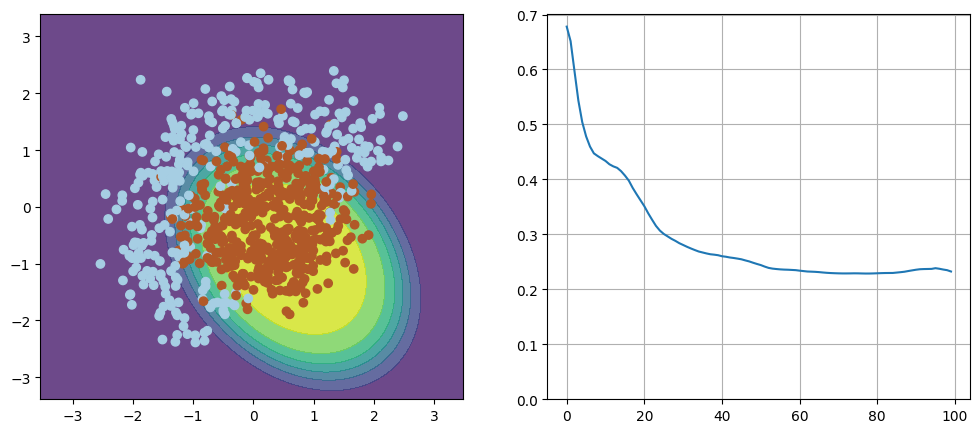

CPU times: user 533 ms, sys: 4.01 ms, total: 537 ms
Wall time: 446 ms


<Figure size 640x480 with 0 Axes>

In [31]:
%%time
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.05
alpha = 0.9
nu = np.zeros_like(w)

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
  idx = np.random.choice(X.shape[0], size=batch_size)
  X_batch = expand(X[idx])
  y_batch = y[idx]

  grad = compute_grad(X_batch, y_batch, w)
  nu = alpha * nu + eta * grad
  w = w - nu

  loss[i] = compute_loss(expand(X), y, w)

visualize(X, y, w, loss)
plt.clf()

### [2] RMSprop

В этом блоке реализуем RMSprop. Эта вариация градиентного спуска позволяет изменять скорость обучения индивидуально для каждого параметра.

$$ G_t^j = \alpha G_{t-1}^j + (1 - \alpha) g_{tj}^2 $$
$$ w_t^j = w_{t-1}^j - \dfrac{\eta}{\sqrt{G_t^j + \varepsilon}} g_{tj} $$

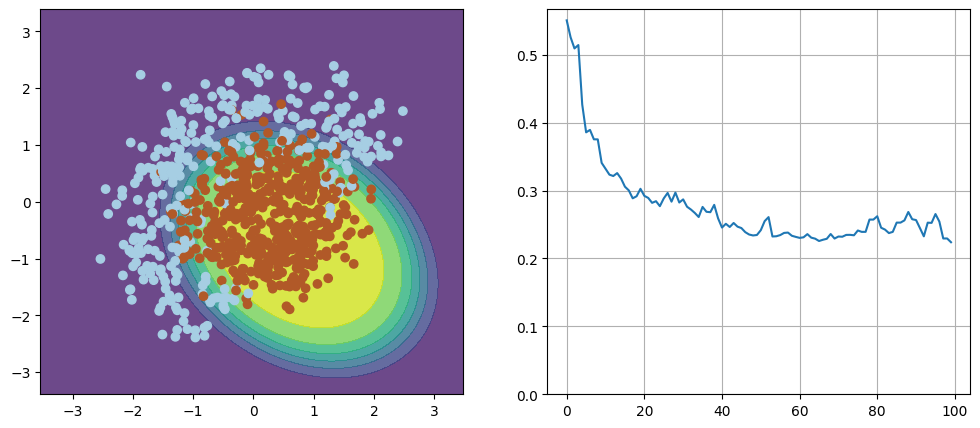

<Figure size 640x480 with 0 Axes>

In [34]:
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.1
alpha = 0.9
g2 = np.zeros_like(w)
eps = 1e-8

n_iter = 100
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
  idx = np.random.choice(X.shape[0], size=batch_size)
  X_batch = expand(X[idx])
  y_batch = y[idx]

  grad = compute_grad(X_batch, y_batch, w)

  g2 = alpha * g2 + (1 - alpha) * grad ** 2
  w = w - eta * grad / (np.sqrt(g2) + eps)

  loss[i] = compute_loss(expand(X), y, w)

visualize(X, y, w, loss)
plt.clf()

Как траектории обучения различных вариаций градиентного спуска различаются между собой? Ожидаемо ли это? Почему? Что нужно сделать, чтобы реализовать Adam?

Momentum SGD 'проваливается' в минимум быстрее из-за накопления градиента       
RMSprop имеет график с колебаниями из-за разного градиента у параметров

### [2] За каждую адекватную вариацию

Если понравилось реализовывать свои градиентные спуски и ты находишься от них под глубоким впечатлением, я могу накинуть дополнительные баллы за реализацию каждой новой адекватной вариации.

#### Adam

В Adam используются скользящие средние как градиентов, так и вторых моментов градиентов.

$$
g_t = \nabla_w L(w_t)
$$
$$
m_t = \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot g_t
$$
$$
v_t = \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot g_t^2
$$
$$
\hat{m}_t = \frac{m_t}{1 - \beta_1^t}, \quad
\hat{v}_t = \frac{v_t}{1 - \beta_2^t}
$$
$$
w_{t+1} = w_t - \eta \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \varepsilon}
$$

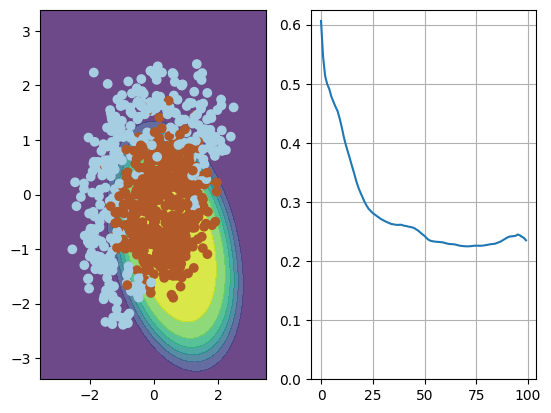

<Figure size 640x480 with 0 Axes>

In [36]:
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.1
beta1 = 0.9
beta2 = 0.999

eps = 1e-8
m = np.zeros_like(w)
v = np.zeros_like(w)

n_iter = 100
batch_size = 4

for i in range(n_iter):
  idx = np.random.choice(X.shape[0], size=batch_size)
  X_batch = expand(X[idx])
  y_batch = y[idx]

  grad = compute_grad(X_batch, y_batch, w)

  m = beta1 * m + (1 - beta1) * grad
  v = beta2 * v + (1 - beta2) * grad ** 2

  m_hat = m / (1 - beta1 ** (i + 1))
  v_hat = v / (1 - beta2 ** (i + 1))

  w = w - eta * m_hat / (np.sqrt(v_hat) + eps)
  loss[i] = compute_loss(expand(X), y, w)

visualize(X, y, w, loss)
plt.clf()



#### AdaGrad

 AdaGrad является модификацией стохастического алгоритма градиентного спуска с отдельной для каждого параметра скоростью обучения. Это увеличивает скорость обучения для параметров с редкими данными и уменьшает скорость обучения для параметров с менее редкими.

$$
g_t = \nabla_w L(w_t)
$$
$$
G_t = G_{t-1} + g_t^2
$$
$$
w_{t+1} = w_t - \frac{\eta}{\sqrt{G_t} + \varepsilon} \cdot g_t
$$



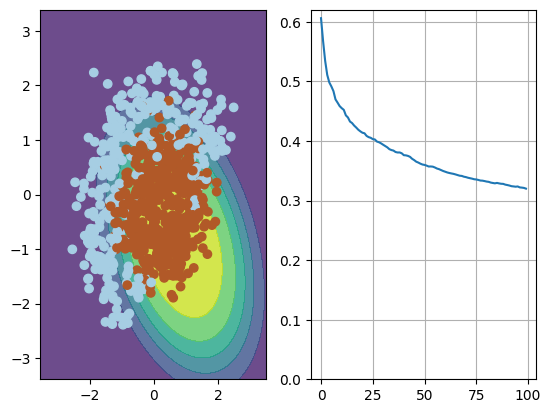

<Figure size 640x480 with 0 Axes>

In [37]:
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1.])

eta = 0.1
G = np.zeros_like(w)

eps = 1e-8


n_iter = 100
batch_size = 4

for i in range(n_iter):
  idx = np.random.choice(X.shape[0], size=batch_size)
  X_batch = expand(X[idx])
  y_batch = y[idx]

  grad = compute_grad(X_batch, y_batch, w)

  G += (grad ** 2)
  w = w - eta * grad / (np.sqrt(G) + eps)
  loss[i] = compute_loss(expand(X), y, w)

visualize(X, y, w, loss)
plt.clf()
